In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (12, 6)

data = pd.read_csv("student_exam_scores.csv")

print("Первые строки таблицы:")
display(data.head())

print("\nИнформация о данных:")
print(data.info())

print("\nОписательная статистика:")
display(data.describe(include='all'))

Первые строки таблицы:


,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   attendance_percent  200 non-null    float64
 4   previous_scores     200 non-null    int64  
 5   exam_score          200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB
None

Описательная статистика:


,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
count,200,200.000000,200.000000,200.000000,200.000000,200.000000
unique,200,NaN,NaN,NaN,NaN,NaN
top,S001,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.325500,6.622000,74.830000,66.800000,33.955000
std,NaN,3.227317,1.497138,14.249905,15.663869,6.789548
min,NaN,1.000000,4.000000,50.300000,40.000000,17.100000
25%,NaN,3.500000,5.300000,62.200000,54.000000,29.500000
50%,NaN,6.150000,6.700000,75.250000,67.500000,34.050000
75%,NaN,9.000000,8.025000,87.425000,80.000000,38.750000


In [37]:
print("\nПропуски по столбцам:")
print(data.isnull().sum())


Пропуски по столбцам:
student_id            0
hours_studied         0
sleep_hours           0
attendance_percent    0
previous_scores       0
exam_score            0
dtype: int64


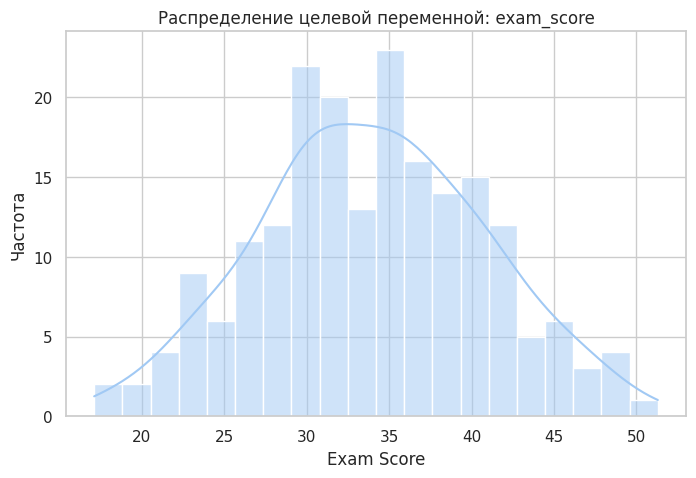

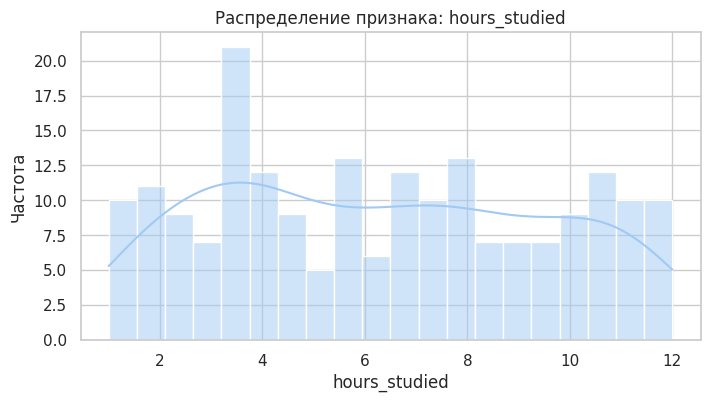

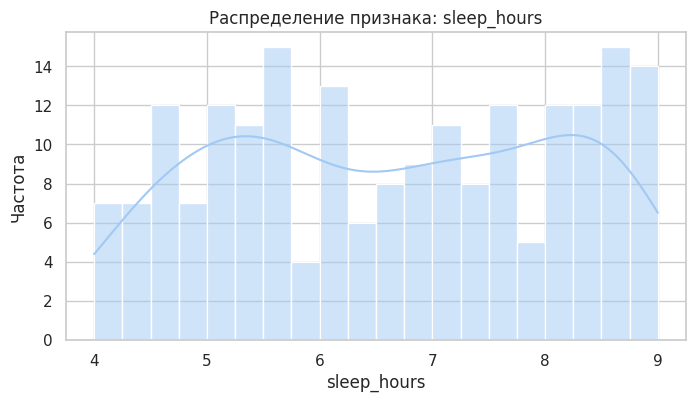

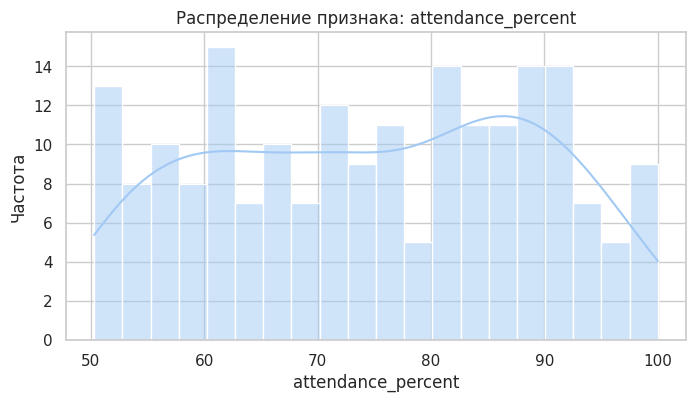

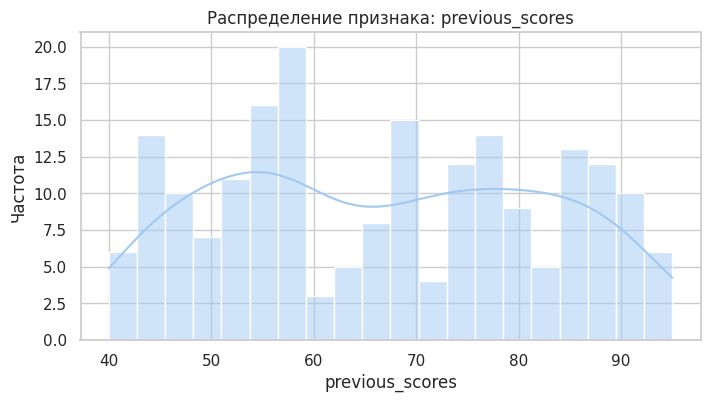

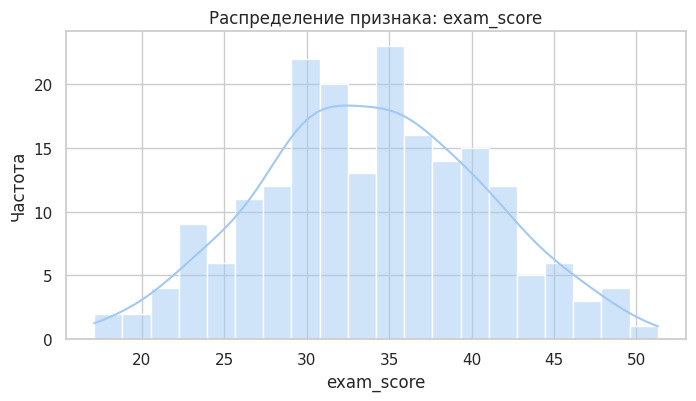

In [38]:
plt.figure(figsize=(8,5))
sns.histplot(data['exam_score'], bins=20, kde=True)
plt.title("Распределение целевой переменной: exam_score")
plt.xlabel("Exam Score")
plt.ylabel("Частота")
plt.show()

numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_features:
    plt.figure(figsize=(8,4))
    sns.histplot(data[col], bins=20, kde=True)
    plt.title(f"Распределение признака: {col}")
    plt.xlabel(col)
    plt.ylabel("Частота")
    plt.show()

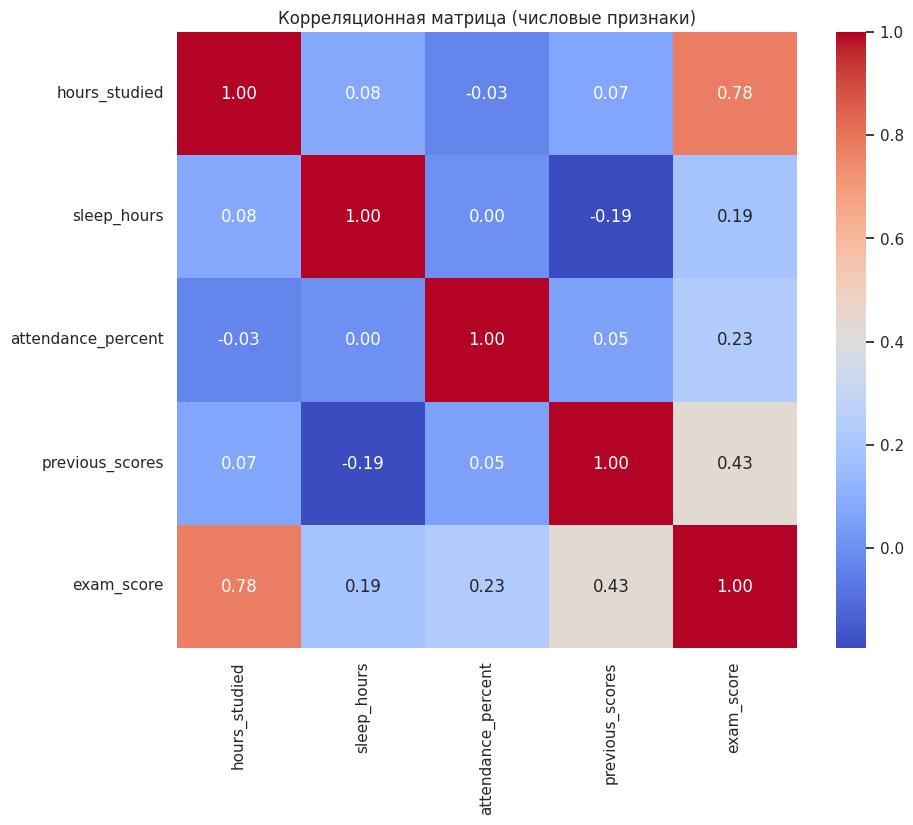

In [39]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляционная матрица (числовые признаки)")
plt.show()


Коэффициенты VIF:


,Feature,VIF
0,hours_studied,1.014944
1,sleep_hours,1.048547
2,attendance_percent,1.004142
3,previous_scores,1.050271


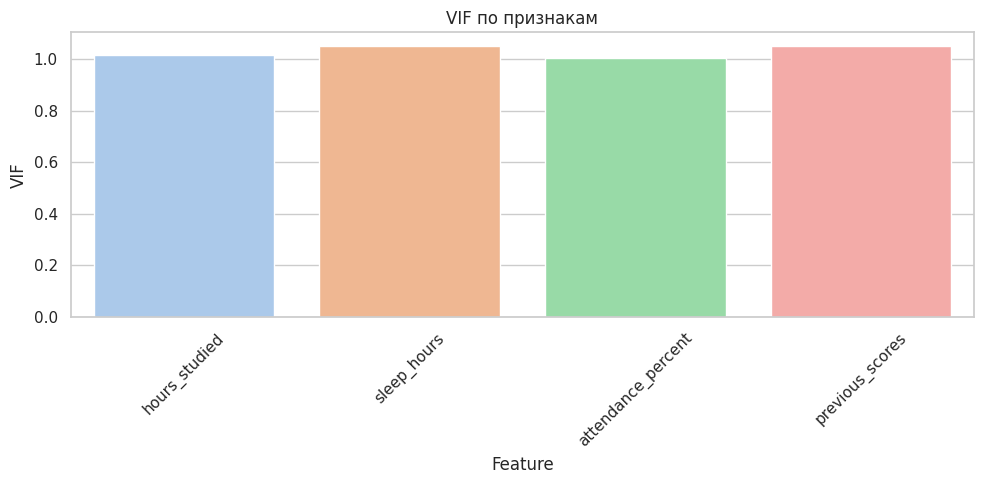

Вывод: признаки с высокой мультиколлинеарностью (VIF>5) не обнаружены.


In [40]:
X_vif = data.select_dtypes(include=['int64', 'float64']).drop(columns=['exam_score'], errors='ignore')
X_vif_const = add_constant(X_vif)  # для корректного подсчёта VIF
vif_data = pd.DataFrame({
    "Feature": X_vif_const.columns,
    "VIF": [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]
})
vif_data = vif_data[vif_data['Feature'] != 'const'].reset_index(drop=True)
print("\nКоэффициенты VIF:")
display(vif_data)

plt.figure(figsize=(10,5))
sns.barplot(data=vif_data, x='Feature', y='VIF', hue='Feature', palette='pastel', legend=False)
plt.title("VIF по признакам")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
high_vif = vif_data[vif_data['VIF'] > 5]
if not high_vif.empty:
    print("Вывод: обнаружены признаки с повышенным VIF (>5):")
    display(high_vif)
else:
    print("Вывод: признаки с высокой мультиколлинеарностью (VIF>5) не обнаружены.")


In [41]:
X = data.drop(columns=['exam_score'])
y = data['exam_score']
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lin_reg = LinearRegression()

lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)
ridge_reg = Ridge(alpha=1.0)

ridge_reg.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_reg.predict(X_test_scaled)

def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, r2, mape

metrics_lin = regression_metrics(y_test, y_pred_lin)
metrics_ridge = regression_metrics(y_test, y_pred_ridge)

print("\nМетрики (до PCA, на test):")
print(f"Линейная регрессия: RMSE={metrics_lin[0]:.3f}, R²={metrics_lin[1]:.3f}, MAPE={metrics_lin[2]:.3f}")
print(f"Гребневая регрессия: RMSE={metrics_ridge[0]:.3f}, R²={metrics_ridge[1]:.3f}, MAPE={metrics_ridge[2]:.3f}")


Метрики (до PCA, на test):
Линейная регрессия: RMSE=5.126, R²=0.505, MAPE=0.122
Гребневая регрессия: RMSE=4.886, R²=0.550, MAPE=0.118


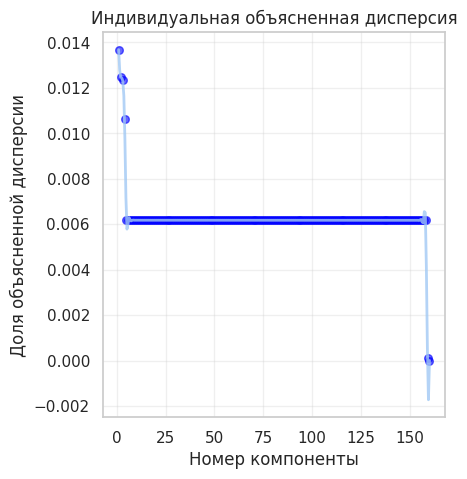

In [ ]:
pca_full = PCA()
pca_full.fit(X_train_scaled)
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative = np.cumsum(explained_variance_ratio)

n_components = len(cumulative)
x_smooth = np.linspace(1, n_components, 300)

from scipy.interpolate import interp1d
cumulative_interp = interp1d(range(1, n_components+1), cumulative, 
                            kind='cubic', fill_value='extrapolate')
cumulative_smooth = cumulative_interp(x_smooth)

individual_interp = interp1d(range(1, n_components+1), explained_variance_ratio, 
                            kind='cubic', fill_value='extrapolate')
individual_smooth = individual_interp(x_smooth)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x_smooth, individual_smooth, 'b-', linewidth=2, alpha=0.8, label='Индивидуальная')
plt.scatter(range(1, n_components+1), explained_variance_ratio, color='blue', alpha=0.6, s=30)
plt.title("Индивидуальная объясненная дисперсия")
plt.xlabel("Номер компоненты")
plt.ylabel("Доля объясненной дисперсии")
plt.grid(True, alpha=0.3)
plt.show()

In [45]:
lin_reg_pca = LinearRegression()
lin_reg_pca.fit(X_train_pca, y_train)
y_pred_lin_pca = lin_reg_pca.predict(X_test_pca)

ridge_reg_pca = Ridge(alpha=1.0)
ridge_reg_pca.fit(X_train_pca, y_train)
y_pred_ridge_pca = ridge_reg_pca.predict(X_test_pca)

metrics_lin_pca = regression_metrics(y_test, y_pred_lin_pca)
metrics_ridge_pca = regression_metrics(y_test, y_pred_ridge_pca)

print("\nМетрики на test (после PCA):")
print(f"Linear (PCA): RMSE={metrics_lin_pca[0]:.3f}, R²={metrics_lin_pca[1]:.3f}, MAPE={metrics_lin_pca[2]:.3f}")
print(f"Ridge  (PCA): RMSE={metrics_ridge_pca[0]:.3f}, R²={metrics_ridge_pca[1]:.3f}, MAPE={metrics_ridge_pca[2]:.3f}")



Метрики на test (после PCA):
Linear (PCA): RMSE=4.345, R²=0.644, MAPE=0.108
Ridge  (PCA): RMSE=4.353, R²=0.643, MAPE=0.108



Сравнение метрик:


,Model,RMSE,R2,MAPE
0,Linear (orig),5.126383,0.504810,0.122267
1,Ridge (orig),4.886268,0.550112,0.118316
2,Linear (PCA),4.345401,0.644197,0.108094
3,Ridge (PCA),4.353472,0.642874,0.108303


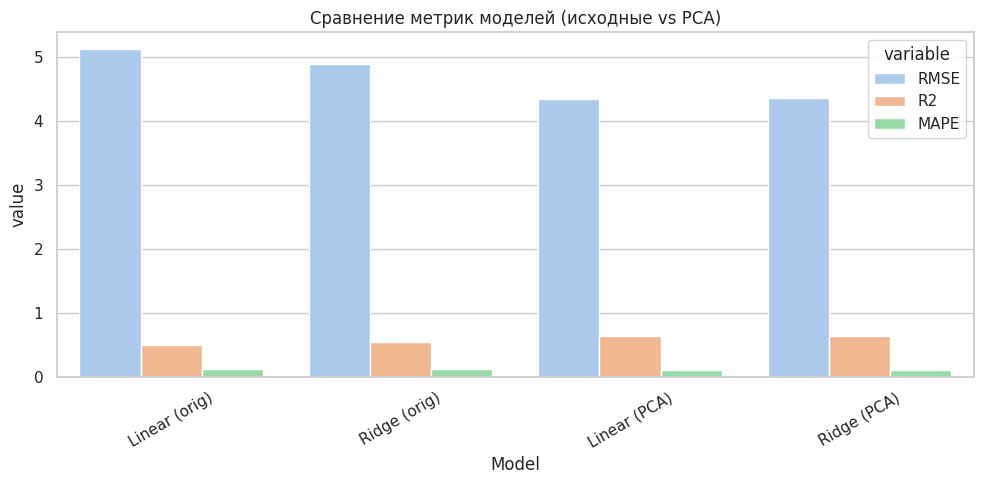

Краткий вывод:
- Лучшая модель на исходных признаках: Ridge (orig) (R² = 0.550)
- Лучшая модель на PCA-признаках: Linear (PCA) (R² = 0.644)
- PCA ухудшило качество модели


In [46]:
comparison = pd.DataFrame({
    "Model": ["Linear (orig)", "Ridge (orig)", "Linear (PCA)", "Ridge (PCA)"],
    "RMSE": [metrics_lin[0], metrics_ridge[0], metrics_lin_pca[0], metrics_ridge_pca[0]],
    "R2":   [metrics_lin[1], metrics_ridge[1], metrics_lin_pca[1], metrics_ridge_pca[1]],
    "MAPE": [metrics_lin[2], metrics_ridge[2], metrics_lin_pca[2], metrics_ridge_pca[2]]
})
print("\nСравнение метрик:")
display(comparison)

melted = comparison.melt(id_vars="Model", value_vars=["RMSE","R2","MAPE"])
plt.figure(figsize=(10,5))
sns.barplot(data=melted, x="Model", y="value", hue="variable", palette="pastel")
plt.title("Сравнение метрик моделей (исходные vs PCA)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

print("Краткий вывод:")
best_orig = "Ridge (orig)" if metrics_ridge[1] > metrics_lin[1] else "Linear (orig)"
best_pca  = "Ridge (PCA)"  if metrics_ridge_pca[1] > metrics_lin_pca[1] else "Linear (PCA)"
print(f"- Лучшая модель на исходных признаках: {best_orig} (R² = {max(metrics_lin[1], metrics_ridge[1]):.3f})")
print(f"- Лучшая модель на PCA-признаках: {best_pca} (R² = {max(metrics_lin_pca[1], metrics_ridge_pca[1]):.3f})")

if best_pca > best_orig:
    print("- PCA улучшило качество модели")
elif best_pca < best_orig:
    print("- PCA ухудшило качество модели")
else:
    print("- PCA не повлияло на качество модели")